In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna

In [69]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, SCORERS

In [4]:
from joblib import dump, load

In [5]:
train = pd.read_csv('../data/tabular-playground-series-aug-2021/train.csv', index_col='id')

In [6]:
test = pd.read_csv('../data/tabular-playground-series-aug-2021/test.csv', index_col='id')

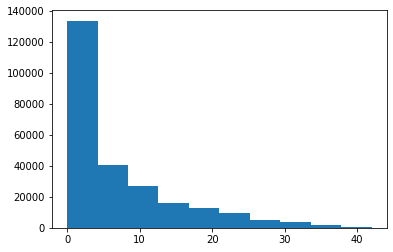

In [10]:
_ = plt.hist(train.loss)

In [45]:
train.loss.value_counts().head()

0    60144
2    22225
1    22069
3    15902
4    13371
Name: loss, dtype: int64

In [15]:
train[train.loss == 0].loss.count()

60144

In [25]:
train[(train.loss > 0) & (train.loss <= 3)].loss.count()

60196

In [31]:
train[(train.loss > 3) & (train.loss <= 9)].loss.count()

61119

In [32]:
train[(train.loss > 9)].loss.count()

68541

In [39]:
def loss_label(loss):
    if loss == 0:
        return 0
    elif loss <=3:
        return 1
    elif loss <=9:
        return 2
    else:
        return 3

In [47]:
train['loss_label'] = train.loss.apply(loss_label)

In [54]:
X = train.drop(['loss', 'loss_label'], axis=1)
y = train.loss_label
loss = train.loss

In [56]:
train[train.loss_label == 0].loss.mean()

0.0

In [57]:
train[train.loss_label == 1].loss.mean()

1.8975513323144395

In [58]:
train[train.loss_label == 2].loss.mean()

6.139514717191053

In [59]:
train[train.loss_label == 3].loss.mean()

17.712230635677916

In [82]:
def gradient_boost(boost):
    score = cross_val_score(boost, X, y, scoring='accuracy', n_jobs=-1, cv=3, verbose=10)
    print(score.mean())
    return boost.fit(X, y)

In [9]:
def objective_lgbm(trial):
    params = {
        'objective': 'rmse',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_threads': 4,
        'feature_pre_filter': trial.suggest_categorical('feature_pre_filter', [True, False]),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'num_leaves': trial.suggest_int('num_leaves', 5, 50),
        'num_trees': trial.suggest_int('num_trees', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0), 
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100)
    }
    
    lg = lgbm.LGBMRegressor(**params)
    
    score = cross_val_score(lg, X, y, scoring='accuracy', n_jobs=-1, cv=3)
    rmse = score.mean()
    return rmse

In [10]:
# study = optuna.create_study(direction="maximize")
# study.optimize(objective_lgbm, n_trials=100)
# print(study.best_trial)

In [11]:
# study.best_params

In [83]:
best_params = {
    'objective': 'cross_entropy',
    'num_threads': 4,
    'lambda_l1': 0.7,
    'lambda_l2': 4.4,
    'num_leaves': 43,
    'num_trees': 1000,
    'learning_rate': 0.02,
    'feature_fraction': 0.25,
    'min_data_in_leaf': 100
}

lgb = gradient_boost(lgbm.LGBMClassifier(**best_params))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.9min finished
/usr/local/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


0.3226119989703277


In [13]:
dump(lgb, '../lgb_c.joblib') 

['../lgb.joblib']